<h1>GAN VaR</h1>

In [1]:
import pandas
import numpy
from scipy.stats import norm
from matplotlib import pyplot
import seaborn
from scipy import stats
from scipy.stats import genpareto
from scipy.optimize import minimize, brute
from scipy.stats import kurtosis, zscore, skew
import torch.nn as nn
import torch
from time import time
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.arima_model import ARMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from arch import arch_model
#from garch import garch
import os

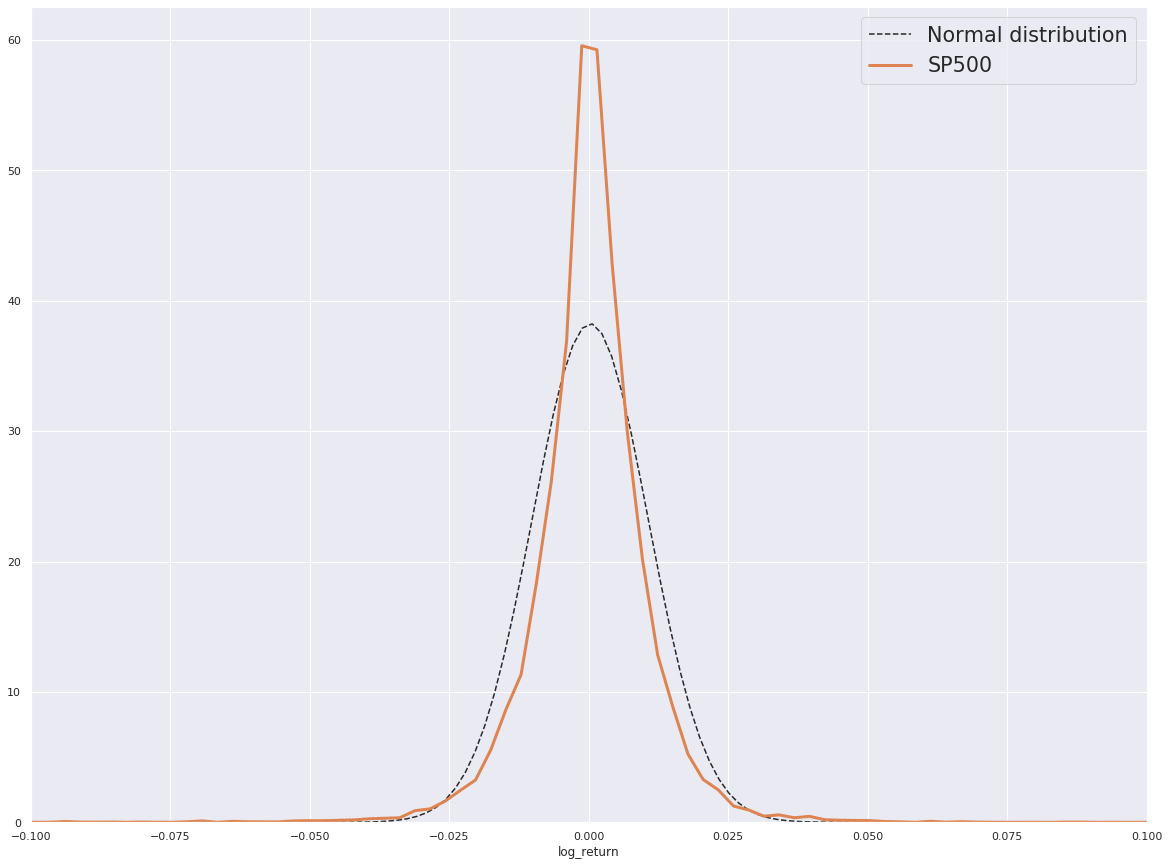

In [2]:
data_file = "/home/leiska/stock-index-data/sp500_data_dots.csv"

price_index = pandas.read_csv(data_file, sep=";", skiprows=6, header=None)
price_index.columns = ["date", "price"]
price_index["price"] = price_index["price"].astype(float)
price_index["log_return"] = numpy.log(price_index["price"]) - numpy.log(price_index["price"].shift(1))
log_return_mean = numpy.mean(price_index["log_return"])
log_return_std = numpy.std(price_index["log_return"])
log_returns_numpy = price_index["log_return"][1:].to_numpy()
price_index["returns"] = price_index["price"] / price_index["price"].shift(1) - 1
returns_numpy = price_index["returns"][1:].to_numpy()

seaborn.set()
pyplot.figure(figsize=(20,15))
seaborn.distplot(price_index["log_return"][1:], kde=False, hist=False, fit=norm, fit_kws={"label": "Normal distribution", "linestyle": "--"})
seaborn.distplot(price_index["log_return"][1:], hist=False, kde_kws={"label": "SP500", "linestyle": "solid", "linewidth": 3})
pyplot.legend(fontsize="xx-large")
pyplot.xlim(-0.1, 0.1)
#pyplot.title("Histogram of daily SP500 log returns")
pyplot.show()

In [4]:
price_index.iloc[10000]

date           1.5.2008
price           1409.34
log_return    0.0169955
returns       0.0171407
Name: 10000, dtype: object

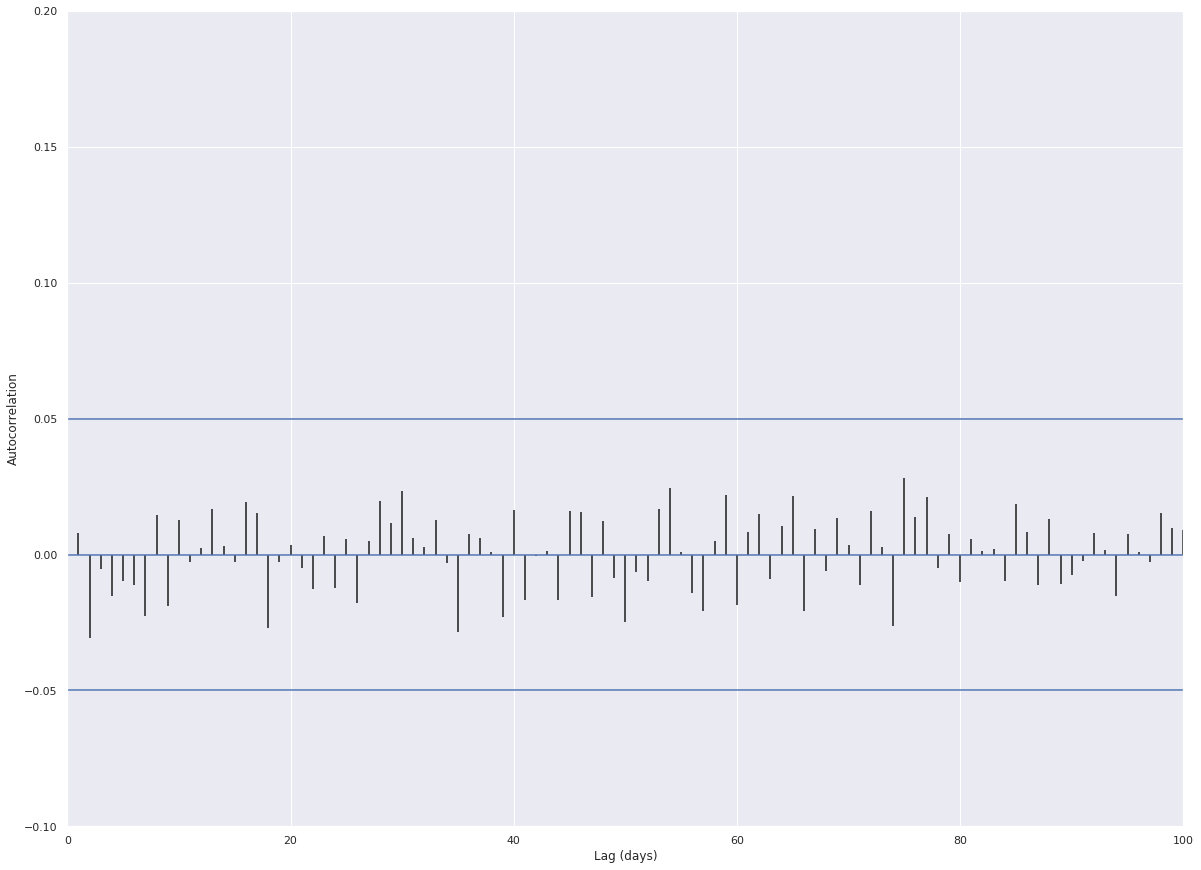

In [3]:
seaborn.set()
pyplot.figure(figsize=(20,15))
pyplot.acorr(price_index["log_return"][1:], normed=True, usevlines=True, maxlags=100)
pyplot.ylim(-0.1, 0.2)
pyplot.xlim(0, 100)
pyplot.axhline(y=0.05)
pyplot.axhline(y=-0.05)
#pyplot.title("SP500 autocorrelation of daily returns")
pyplot.xlabel("Lag (days)")
pyplot.ylabel("Autocorrelation")
pyplot.show()

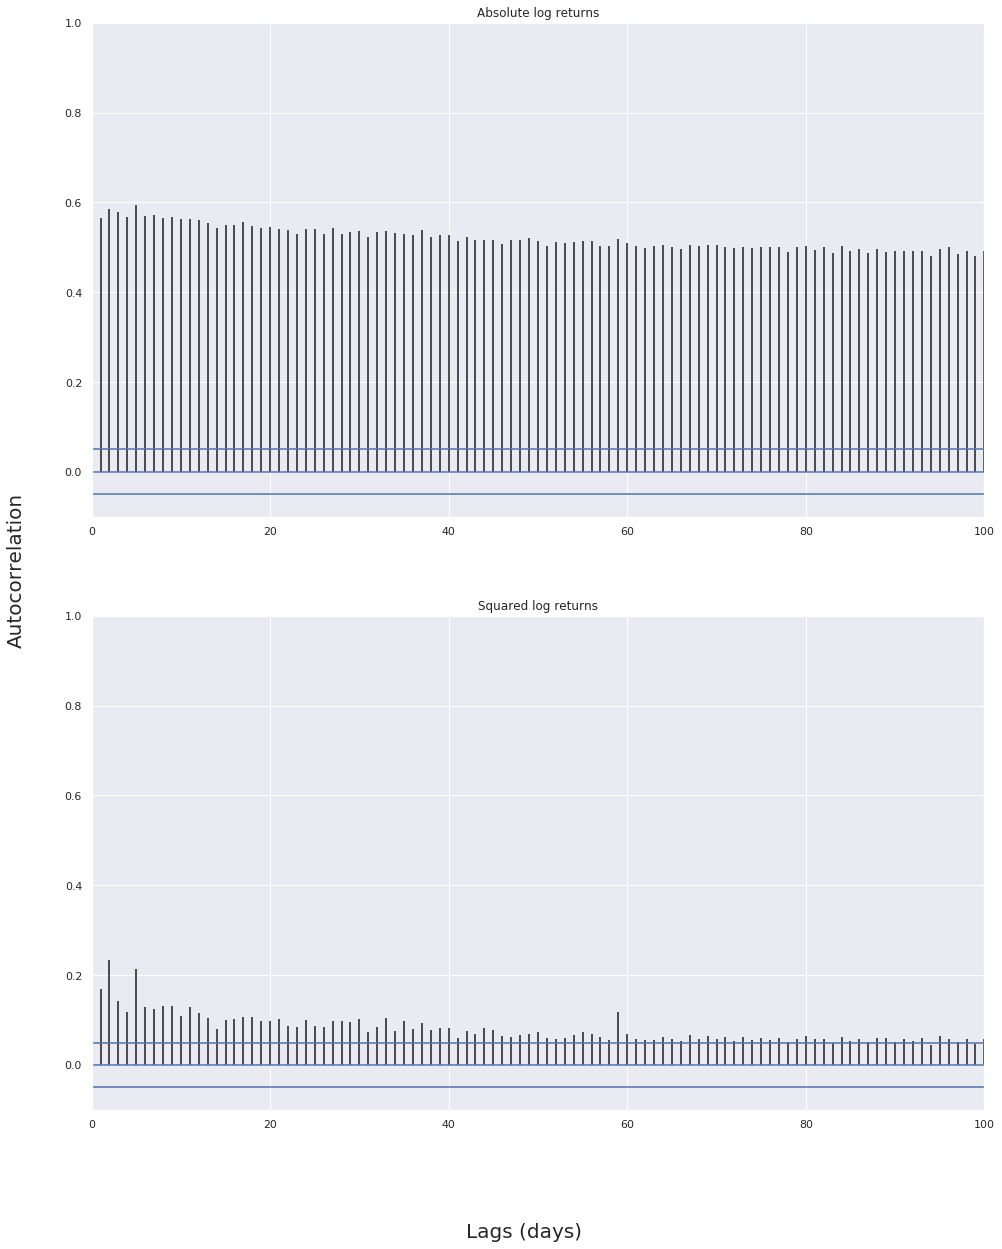

In [4]:
fig, (ax1, ax2) = pyplot.subplots(2, figsize=(16,20))
ax1.set_xlim(0,100)
ax1.set_ylim(-0.1,1)
ax1.axhline(y=-0.05)
ax1.axhline(y=0.05)
ax1.acorr(numpy.abs(price_index["log_return"][1:]), 
                       normed=True, 
                       usevlines=True, 
                       maxlags=100)
ax1.set_title("Absolute log returns")

ax2.set_xlim(0,100)
ax2.set_ylim(-0.1,1)
ax2.axhline(y=-0.05)
ax2.axhline(y=0.05)
ax2.acorr((price_index["log_return"][1:])**2, 
              normed=True, 
              usevlines=True, 
              maxlags=100)
ax2.set_title("Squared log returns")
#ax2.set_xlabel("Lags (days)", fontsize=20)
fig.text(0.5, 0.04, "Lags (days)", ha='center', va='center', fontsize=20)
fig.text(0.06, 0.5, "Autocorrelation", ha='center', va='center', rotation='vertical', fontsize=20)
pyplot.show()

<h1>Historical simulation</h1>

(12341,)
12341


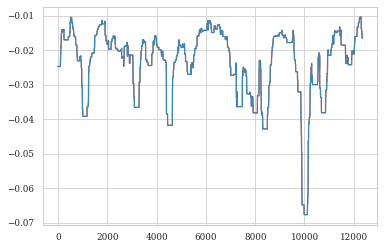

In [99]:
alpha = 0.01
window_size = 250
negative_log_returns = - price_index["log_return"]

def historical_simulation(data, window_size, alpha):
    value_at_risk_estimates = data.rolling(window_size).quantile(alpha)
    return value_at_risk_estimates


def other_hs(returns, window_size, alpha):
    usable_returns = returns.iloc[window_size:]
    var_estimates = []
    for idx, daily_return in enumerate(usable_returns):
        var_estimate = numpy.quantile(returns.iloc[idx:window_size+idx], alpha)
        var_estimates.append(var_estimate)
    return var_estimates

value_at_risk_estimates_hs = historical_simulation(negative_log_returns, window_size, alpha)
value_at_risk_estimates_other_hs = other_hs(negative_log_returns, window_size, alpha)

print(value_at_risk_estimates_hs[250:].shape)
print(len(value_at_risk_estimates_other_hs))
pyplot.plot(value_at_risk_estimates_hs[250:].to_numpy())
pyplot.plot(value_at_risk_estimates_other_hs)
pyplot.show()

<h1>GAN model</h1>

In [9]:
LATENT_DIMENSION = 50
WINDOW = 500
BETA_1 = 0.5
BETA_2 = 0.999
LEARNING_RATE = 0.0001
CLIP_VALUE = 0.02
NUMBER_OF_EPOCHS = 2000
N_CRITIC = 5
DROPOUT_PROB = 0.2

class Generator(nn.Module):
    def __init__(self, window):
        super(Generator, self).__init__()
        self.window = window
        
        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat), nn.Dropout(DROPOUT_PROB)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(LATENT_DIMENSION, 100, normalize=False),
            *block(100, 100, normalize=False),
            *block(100, 100, normalize=False),
            #*block(1024, 1024, normalize=False),
            nn.Linear(100, self.window),
            nn.Tanh()
        )

    def forward(self, z):
        returns = self.model(z)
        #returns = returns.view(returns.size(0), 100)
        return returns

    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(WINDOW, 100),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(100, 50),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(50, 1),
            nn.Sigmoid(),
        )

    def forward(self, returns):
        returns_flat = returns.view(returns.size(0), -1)
        validity = self.model(returns_flat)
        return validity
    
class ReturnsDataset(torch.utils.data.Dataset):
    
    def __init__(self, returns, window):
        self.samples = returns
        self.window = window
    """
    def __len__(self):
        return len(self.samples) - self.window
    """
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, index):
        return self.samples[index]
    """
    def __getitem__(self, index):
        #index *= 100
        return self.samples[index:index+self.window]
    """

def get_rolling_returns(returns, n, step):
    returns_first_n = returns[:n]

    array_size = int(returns_first_n.shape[0] / step) - int(WINDOW/step) + 1
    returns_rolling = numpy.empty((array_size, WINDOW))
    for i in range(array_size):
        returns_window = returns_first_n[i*step:i*step+WINDOW]
        returns_rolling[i] = returns_window
    return returns_rolling

log_returns_rolling = get_rolling_returns(log_returns_numpy, 10000, 50)
print(log_returns_rolling.shape)

returns_dataset = ReturnsDataset(log_returns_rolling, WINDOW)
returns_dataloader = torch.utils.data.DataLoader(returns_dataset, batch_size=8, shuffle=True)

    
adversarial_loss = torch.nn.BCELoss()

generator = Generator(500)
discriminator = Discriminator()


#optimizer_G = torch.optim.RMSprop(generator.parameters(), lr=LEARNING_RATE)
#optimizer_D = torch.optim.RMSprop(discriminator.parameters(), lr=LEARNING_RATE)
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, BETA_2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.00001, betas=(0.1, BETA_2))

(191, 500)


<h2>Path simulator evaluation metrics</h2>

In [130]:
def ACFscore(real_path, generator, sample_size=100, lags=100):
    
    sample_fake_autocorrelations = []
    generator.eval()
    for i in range(sample_size):
        noise = torch.FloatTensor(numpy.random.normal(0, 1, (1,LATENT_DIMENSION)))
        fake_path = generator(noise).detach().numpy().flatten()
        fake_autocorrelation = acf(numpy.abs(fake_path), nlags=lags)
        sample_fake_autocorrelations.append(fake_autocorrelation)
        
    mean_fake_autocorrelation = numpy.mean(sample_fake_autocorrelations, axis=0)
    real_autocorrelation = acf(numpy.abs(real_path), nlags=lags)

    return numpy.linalg.norm(real_autocorrelation - mean_fake_autocorrelation)

def kurtosis_score(real_path, generator, sample_size=100):
    
    sample_fake_kurtoses = []
    generator.eval()
    for i in range(sample_size):
        noise = torch.FloatTensor(numpy.random.normal(0, 1, (1,LATENT_DIMENSION)))
        fake_path = generator(noise).detach().numpy().flatten()
        fake_kurtosis = kurtosis(fake_path, fisher=False)
        sample_fake_kurtoses.append(fake_kurtosis)
        
    mean_fake_kurtosis = numpy.mean(sample_fake_kurtoses)
    real_kurtosis = kurtosis(real_path, fisher=False)
    
    return numpy.linalg.norm(real_kurtosis - mean_fake_kurtosis)

<h2>Basic GAN training loop</h2>

In [131]:
def train_gan(generator, discriminator, optimizer_G, optimizer_D, dataloader, model_path, epochs, verbose=False):
    
    stop_epoch = 0
    min_kurt_score = 100
    min_acf_score = 100
    for epoch in range(epochs):
        start = time()
        for i, data in enumerate(dataloader):

            real_returns = torch.autograd.Variable(data.type(torch.FloatTensor))

            valid_noisy_label = numpy.random.uniform(0.9, 1.1)
            fake_noisy_label = numpy.random.uniform(0.1, 0.2)
            valid = torch.autograd.Variable(torch.FloatTensor(real_returns.shape[0], 1).fill_(valid_noisy_label), requires_grad=False)
            fake = torch.autograd.Variable(torch.FloatTensor(real_returns.shape[0], 1).fill_(fake_noisy_label), requires_grad=False)

            optimizer_D.zero_grad()

            noise = torch.autograd.Variable(torch.FloatTensor(numpy.random.normal(0, 1, (real_returns.shape[0], LATENT_DIMENSION))))
            fake_returns = generator(noise)

            real_loss = adversarial_loss(discriminator(real_returns), valid)
            fake_loss = adversarial_loss(discriminator(fake_returns.detach()), fake)
            discriminator_loss = (real_loss + fake_loss) / 2

            discriminator_loss.backward()
            optimizer_D.step()

            if i % N_CRITIC == 0:
                optimizer_G.zero_grad()

                generated_returns = generator(noise)

                generator_loss = adversarial_loss(discriminator(generated_returns), valid)
                generator_loss.backward()
                optimizer_G.step()


        end = time()
        if verbose:
            print(
                "[Epoch %d/%d] [D loss: %f] [G loss: %f] %.2f seconds"
                % (epoch+1, epochs, discriminator_loss.item(), generator_loss.item(), end - start)
                )
        
        kurt_score = kurtosis_score(log_returns_numpy[:10000], generator, sample_size=200)
        if kurt_score < min_kurt_score:
            torch.save(generator.state_dict(), model_path)
            stop_epoch = epoch + 1

        min_kurt_score = min(kurt_score, min_kurt_score)
        """
        acf_score = ACFscore(log_returns_numpy[:10000], generator, sample_size=200)
        if acf_score < min_acf_score:
            torch.save(generator.state_dict(), model_path)
            stop_epoch = epoch + 1

        min_acf_score = min(acf_score, min_acf_score)
        """

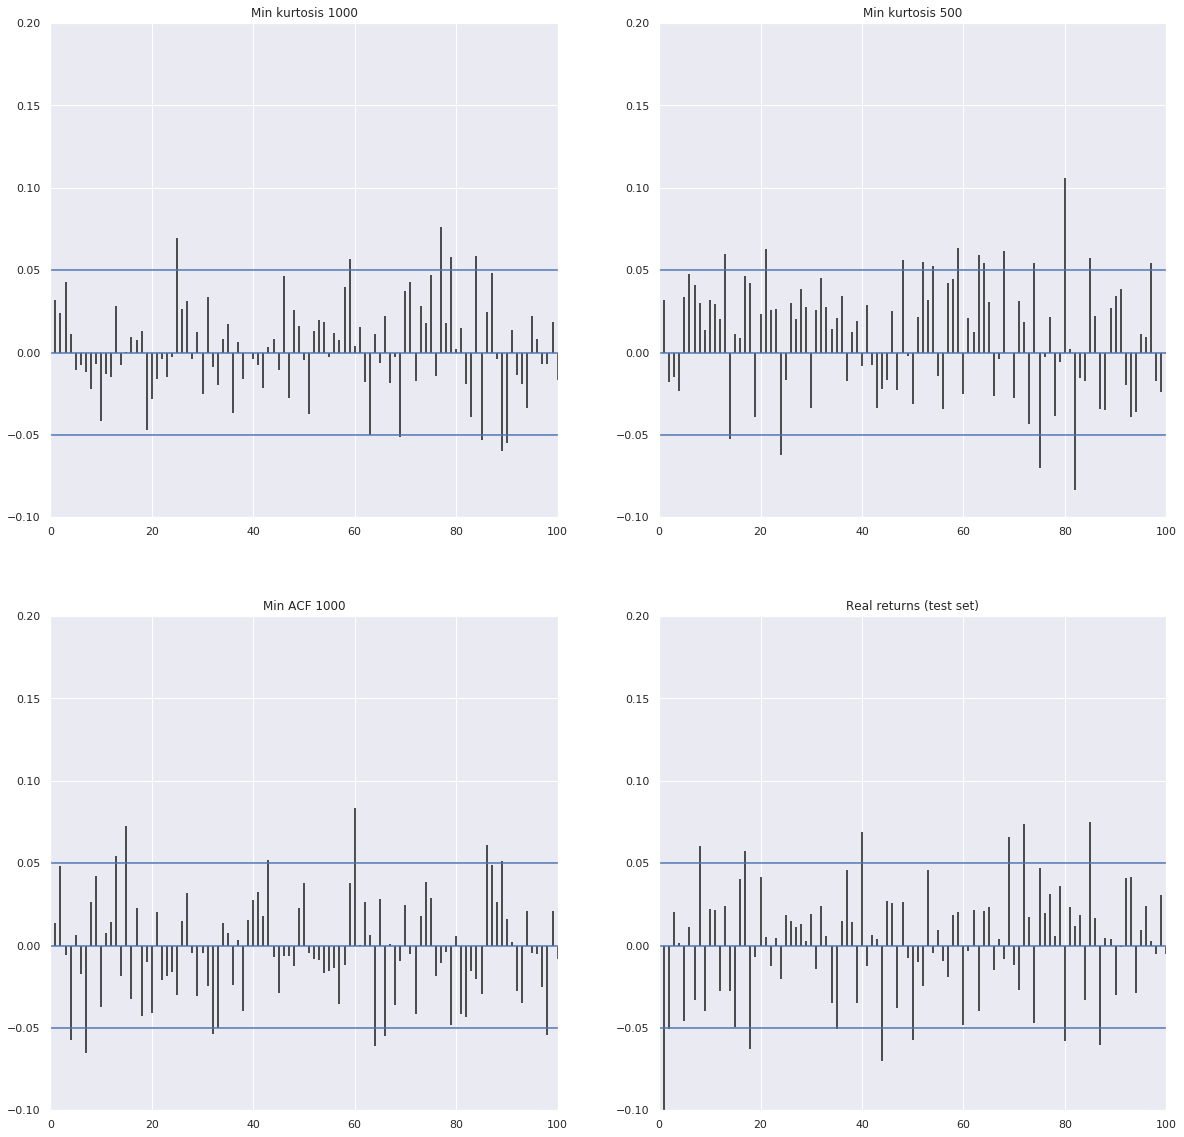

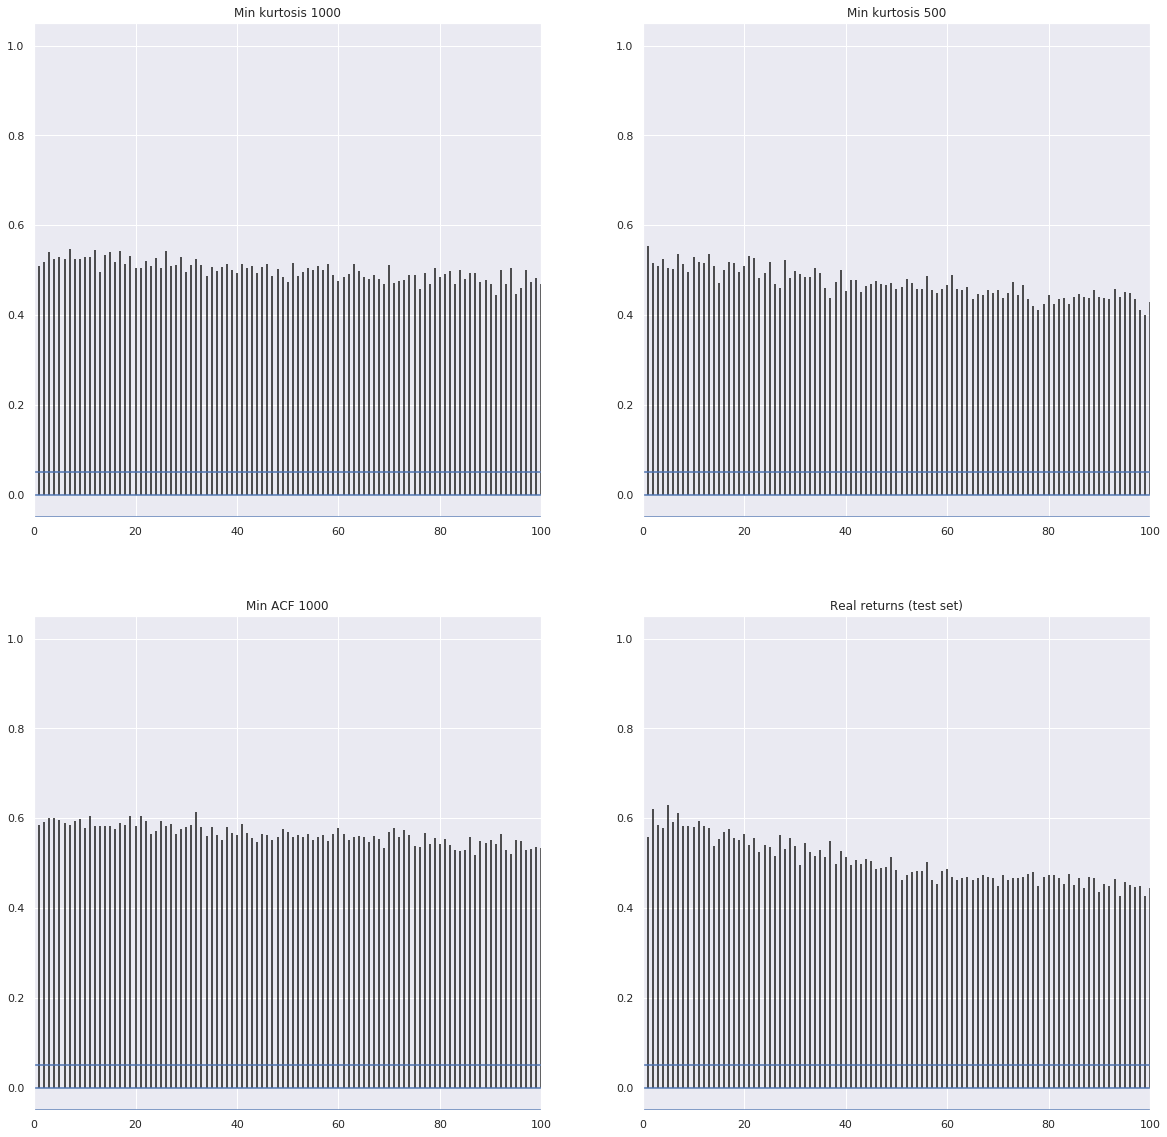

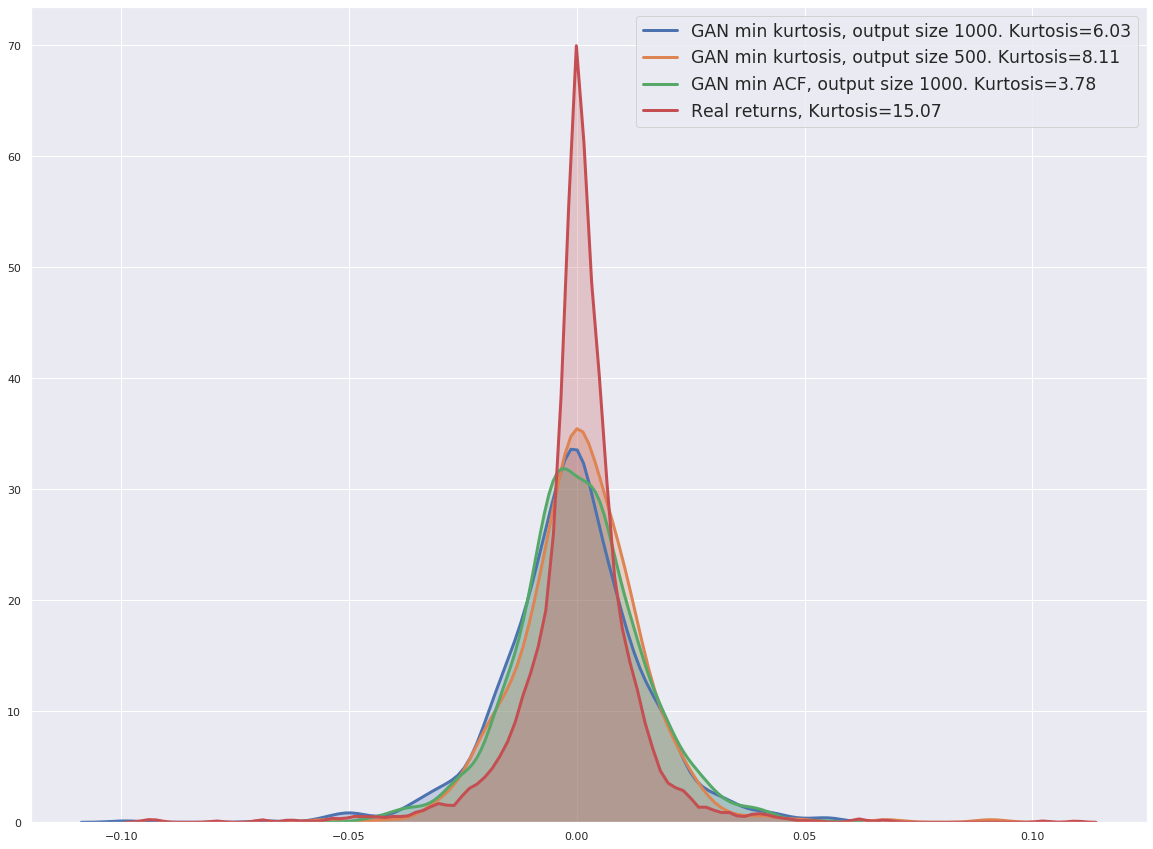

In [10]:
PATH = "gan-models/value-at-risk-generators/generator_noisylabels_3leakyrelu_layers_dropout_8batch_output1000_minkurtscore_50step_0.pt"

def generate_fake_returns(model_path, window):
    generator_trained = Generator(window)
    generator_trained.load_state_dict(torch.load(model_path))
    generator_trained.eval()

    noise = torch.FloatTensor(numpy.random.normal(0, 1, (1,LATENT_DIMENSION)))
    fake_returns = generator_trained(noise).detach().numpy().flatten()
    return fake_returns

fake_returns_minkurt1000 = generate_fake_returns("gan-models/value-at-risk-generators/generator_noisylabels_3leakyrelu_layers_dropout_8batch_output1000_minkurtscore_50step_0.pt", 1000)
fake_returns_minkurt500 = generate_fake_returns("gan-models/value-at-risk-generators/generator_noisylabels_3leakyrelu_layers_dropout_8batch_output500_minkurtscore_50step_0.pt", 500)
fake_returns_minacf1000 = generate_fake_returns("gan-models/value-at-risk-generators/generator_noisylabels_3leakyrelu_layers_dropout_8batch_output1000_minacfscore_50step_0.pt", 1000)



seaborn.set()
fig = pyplot.figure(figsize=(20,20))

pyplot.subplot(221)
pyplot.acorr(fake_returns_minkurt1000, normed=True, usevlines=True, maxlags=100)
pyplot.title("Min kurtosis 1000")
pyplot.ylim(-0.1, 0.2)
pyplot.xlim(0, 100)
pyplot.axhline(y=0.05)
pyplot.axhline(y=-0.05)

pyplot.subplot(222)
pyplot.acorr(fake_returns_minkurt500, normed=True, usevlines=True, maxlags=100)
pyplot.title("Min kurtosis 500")
pyplot.ylim(-0.1, 0.2)
pyplot.xlim(0, 100)
pyplot.axhline(y=0.05)
pyplot.axhline(y=-0.05)

pyplot.subplot(223)
pyplot.acorr(fake_returns_minacf1000, normed=True, usevlines=True, maxlags=100)
pyplot.title("Min ACF 1000")
pyplot.ylim(-0.1, 0.2)
pyplot.xlim(0, 100)
pyplot.axhline(y=0.05)
pyplot.axhline(y=-0.05)

pyplot.subplot(224)
pyplot.acorr(log_returns_numpy[10000:12500], normed=True, usevlines=True, maxlags=100)
pyplot.title("Real returns (test set)")
pyplot.ylim(-0.1, 0.2)
pyplot.xlim(0, 100)
pyplot.axhline(y=0.05)
pyplot.axhline(y=-0.05)

fig = pyplot.figure(figsize=(20,20))

pyplot.subplot(221)
pyplot.acorr(numpy.abs(fake_returns_minkurt1000), normed=True, usevlines=True, maxlags=100)
pyplot.title("Min kurtosis 1000")
pyplot.xlim(0, 100)
pyplot.axhline(y=0.05)
pyplot.axhline(y=-0.05)

pyplot.subplot(222)
pyplot.acorr(numpy.abs(fake_returns_minkurt500), normed=True, usevlines=True, maxlags=100)
pyplot.title("Min kurtosis 500")
pyplot.xlim(0, 100)
pyplot.axhline(y=0.05)
pyplot.axhline(y=-0.05)

pyplot.subplot(223)
pyplot.acorr(numpy.abs(fake_returns_minacf1000), normed=True, usevlines=True, maxlags=100)
pyplot.title("Min ACF 1000")
pyplot.xlim(0, 100)
pyplot.axhline(y=0.05)
pyplot.axhline(y=-0.05)

pyplot.subplot(224)
pyplot.acorr(numpy.abs(log_returns_numpy[10000:12500]), normed=True, usevlines=True, maxlags=100)
pyplot.title("Real returns (test set)")
pyplot.xlim(0, 100)
pyplot.axhline(y=0.05)
pyplot.axhline(y=-0.05)

pyplot.figure(figsize=(20,15))

seaborn.kdeplot(fake_returns_minkurt1000, shade=True, linewidth=3, 
                label="GAN min kurtosis, output size 1000. Kurtosis={:.2f}".format(kurtosis(fake_returns_minkurt1000, fisher=False)))
seaborn.kdeplot(fake_returns_minkurt500, shade=True, linewidth=3, 
                label="GAN min kurtosis, output size 500. Kurtosis={:.2f}".format(kurtosis(fake_returns_minkurt500, fisher=False)))
seaborn.kdeplot(fake_returns_minacf1000, shade=True, linewidth=3, 
                label="GAN min ACF, output size 1000. Kurtosis={:.2f}".format(kurtosis(fake_returns_minacf1000, fisher=False)))
seaborn.kdeplot(log_returns_numpy[10000:12500], shade=True, linewidth=3, 
                label="Real returns, Kurtosis={:.2f}".format(kurtosis(log_returns_numpy[10000:12500], fisher=False)))
pyplot.legend(fontsize="x-large")
pyplot.show()

In [30]:
from scipy.stats import skew

print("Kurtosis (real): {}".format(kurtosis(log_returns_numpy, fisher=False)))
print("Variance (real): {}".format(numpy.var(log_returns_numpy)))
print("Skew (real): {}".format(skew(log_returns_numpy)))
print("Kurtosis (fake): {}".format(kurtosis(fake_returns, fisher=False)))
print("Variance (fake) {}".format(numpy.var(fake_returns)))
print("Skew (fake): {}".format(skew(fake_returns)))

Kurtosis (real): 29.45771666580626
Variance (real): 0.00010876426193106148
Skew (real): -1.025891351069498
Kurtosis (fake): 3.336510362547593
Variance (fake) 0.011879467405378819
Skew (fake): -0.2978432774543762


In [132]:
TEST_START = 10000
TEST_END = 12500

def compute_value_at_risk(log_returns, epochs, train_days, step, name):
    value_at_risk_estimates = []
    #train_returns = log_returns[:train_days]
    test_returns = log_returns[TEST_START:TEST_END]
    for day in range(0, test_returns.shape[0], step):

        log_returns_rolling = get_rolling_returns(log_returns[TEST_START-train_days+day:], train_days, step)
        returns_dataset = ReturnsDataset(log_returns_rolling, WINDOW)
        returns_dataloader = torch.utils.data.DataLoader(returns_dataset, batch_size=8, shuffle=True)

        model_path = name + "_{}.pt".format(day)
        generator = Generator()
        discriminator = Discriminator()
        optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, BETA_2))
        optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.00001, betas=(0.1, BETA_2))
        
        train_gan(generator, discriminator, optimizer_G, optimizer_D, returns_dataloader, model_path, epochs)

        generator_trained = Generator()
        generator_trained.load_state_dict(torch.load(model_path))
        generator_trained.eval()
        
        for i in range(step):
            noise = torch.FloatTensor(numpy.random.normal(0, 1, (100,LATENT_DIMENSION)))
            fake_returns = generator_trained(noise).detach().numpy()
            value_at_risk = -numpy.quantile(fake_returns, alpha, axis=1)
            value_at_risk_estimates.append(numpy.mean(value_at_risk))
        
        print("{0}/{1}".format(day, test_returns.shape[0]))
        
    return value_at_risk_estimates

In [318]:
noise = torch.FloatTensor(numpy.random.normal(0, 1, (100,LATENT_DIMENSION)))
fake_returns = generator_trained(noise).detach().numpy()
value_at_risk = -numpy.quantile(fake_returns, alpha, axis=1)
print(numpy.mean(value_at_risk))

0.022587498119845985


In [137]:
value_at_risk_estimates = compute_value_at_risk(log_returns_numpy, 
                                                epochs=500, 
                                                train_days=5000, step=1,
                                                name="gan-models/value-at-risk-generators/generator_noisylabels_3leakyrelu_layers_dropout_8batch_output500_minkurtscore_1step_5000_train_days_500_epoch")
with open("VaR_estimates_generator_noisylabels_3leakyrelu_layers_dropout_8batch_output500_minkurtscore_1step_5000_train_days_500_epoch.txt", "wt") as f:
    print(*value_at_risk_estimates, sep="\n", file=f)

0/2500
1/2500
2/2500
3/2500
4/2500
5/2500
6/2500
7/2500
8/2500
9/2500
10/2500
11/2500
12/2500
13/2500
14/2500
15/2500
16/2500
17/2500
18/2500
19/2500
20/2500
21/2500
22/2500
23/2500
24/2500
25/2500
26/2500
27/2500
28/2500
29/2500
30/2500
31/2500
32/2500
33/2500
34/2500
35/2500
36/2500
37/2500
38/2500
39/2500
40/2500
41/2500
42/2500
43/2500
44/2500
45/2500
46/2500
47/2500
48/2500
49/2500
50/2500
51/2500
52/2500
53/2500


KeyboardInterrupt: 

<h2>VaR backtesting procedures</h2>
<br>
Taken from https://github.com/BayerSe/VaR-Backtesting

In [134]:
class Backtest:
    def __init__(self, index, actual, forecast, alpha):
        self.index = index
        self.actual = actual
        self.forecast = forecast
        self.alpha = alpha

    def hit_series(self):
        return (self.actual < self.forecast) * 1

    def number_of_hits(self):
        return self.hit_series().sum()

    def hit_rate(self):
        return self.hit_series().mean()

    def expected_hits(self):
        return self.actual.size * self.alpha

    def plot(self, file_name=None):

        # Re-add the time series index
        r = pandas.Series(self.actual, index=self.index)
        q = pandas.Series(self.forecast, index=self.index)

        seaborn.set_context("paper")
        seaborn.set_style("whitegrid", {"font.family": "serif", "font.serif": "Computer Modern Roman", "text.usetex": True})

        # Hits
        ax = r[r <= q].plot(color="red", marker="o", ls="None", figsize=(6, 3.5))
        for h in r[r <= q].index:
            pyplot.axvline(h, color="black", alpha=0.4, linewidth=1, zorder=0)

        # Positive returns
        r[q < r].plot(ax=ax, color="green", marker="o", ls="None")

        # Negative returns but no hit
        r[(q <= r) & (r <= 0)].plot(ax=ax, color="orange", marker="o", ls="None")

        # VaR
        q.plot(ax=ax, grid=False, color="black", rot=0)

        # Axes
        pyplot.xlabel("")
        pyplot.ylabel("Log Return")
        ax.yaxis.grid()

        seaborn.despine()
        if file_name is None:
            pyplot.show()
        else:
            pyplot.savefig(file_name, bbox_inches="tight")
        pyplot.close("all")

    def lr_bt(self):
        """Likelihood ratio framework of Christoffersen (1998)"""
        hits = self.hit_series()   # Hit series
        tr = hits[1:] - hits[:-1]  # Sequence to find transitions

        # Transitions: nij denotes state i is followed by state j nij times
        n01, n10 = (tr == 1).sum(), (tr == -1).sum()
        n11, n00 = (hits[1:][tr == 0] == 1).sum(), (hits[1:][tr == 0] == 0).sum()

        # Times in the states
        n0, n1 = n01 + n00, n10 + n11
        n = n0 + n1

        # Probabilities of the transitions from one state to another
        p01, p11 = n01 / (n00 + n01), n11 / (n11 + n10)
        p = n1 / n

        if n1 > 0:
            # Unconditional Coverage
            uc_h0 = n0 * numpy.log(1 - self.alpha) + n1 * numpy.log(self.alpha)
            uc_h1 = n0 * numpy.log(1 - p) + n1 * numpy.log(p)
            uc = -2 * (uc_h0 - uc_h1)

            # Independence
            ind_h0 = (n00 + n01) * numpy.log(1 - p) + (n01 + n11) * numpy.log(p)
            ind_h1 = n00 * numpy.log(1 - p01) + n01 * numpy.log(p01) + n10 * numpy.log(1 - p11)
            if p11 > 0:
                ind_h1 += n11 * numpy.log(p11)
            ind = -2 * (ind_h0 - ind_h1)

            # Conditional coverage
            cc = uc + ind

            # Stack results
            df = pandas.concat([pandas.Series([uc, ind, cc]),
                            pandas.Series([1 - stats.chi2.cdf(uc, 1),
                                       1 - stats.chi2.cdf(ind, 1),
                                       1 - stats.chi2.cdf(cc, 2)])], axis=1)
        else:
            df = pandas.DataFrame(numpy.zeros((3, 2))).replace(0, numpy.nan)

        # Assign names
        df.columns = ["Statistic", "p-value"]
        df.index = ["Unconditional", "Independence", "Conditional"]

        return df

    def dq_bt(self, hit_lags=4, forecast_lags=1):
        """Dynamic Quantile Test (Engle & Manganelli, 2004)"""
        try:
            hits = self.hit_series()
            p, q, n = hit_lags, forecast_lags, hits.size
            pq = max(p, q - 1)
            y = hits[pq:] - self.alpha  # Dependent variable
            x = numpy.zeros((n - pq, 1 + p + q))
            x[:, 0] = 1  # Constant

            for i in range(p):  # Lagged hits
                x[:, 1 + i] = hits[pq-(i+1):-(i+1)]

            for j in range(q):  # Actual + lagged VaR forecast
                if j > 0:
                    x[:, 1 + p + j] = self.forecast[pq-j:-j]
                else:
                    x[:, 1 + p + j] = self.forecast[pq:]

            beta = numpy.dot(numpy.linalg.inv(numpy.dot(x.T, x)), numpy.dot(x.T, y))
            lr_dq = numpy.dot(beta, numpy.dot(numpy.dot(x.T, x), beta)) / (self.alpha * (1-self.alpha))
            p_dq = 1 - stats.chi2.cdf(lr_dq, 1+p+q)

        except:
            lr_dq, p_dq = numpy.nan, numpy.nan

        return pandas.Series([lr_dq, p_dq],
                         index=["Statistic", "p-value"], name="DQ")
    """
    def ljung_box(self):
        
        hits = self.hit_series()
        lags = int(numpy.log(hits.shape[0]))
        result_df = acorr_ljungbox(hits, lags=lags)
        
        return result_df
    """

    def autocorr(self, t=1):
        hits = self.hit_series()
        return numpy.corrcoef(numpy.array([hits[:-t], hits[t:]]))
    
    def ljung_box(self):
        n = self.hit_series().shape[0]
        lags = int(numpy.log(n))
        
        autocorr_sum = 0
        for i in range(1, lags+1):
            autocorr_i = self.autocorr(t=i)[0][1]
            autocorr_sum += autocorr_i**2 / (n-i)
            
        test_statistic = n * (n+2) * autocorr_sum
        
        p_value = stats.chi2.sf(test_statistic, lags)
        return (test_statistic, p_value)

[0.21612715 0.21781986 0.22255604 ... 0.2350458  0.22933912 0.23314649]

GAN Christoffersen conditional coverage test
statistic: nan
p-value: nan

GAN Dynamic quantile test
statistic: nan
p-value: nan

GAN Ljung-Box test
statistic: nan
p-value: nan

HS Christoffersen
statistic: 8.8550
p-value: 0.0119

HS dynamic quantile
statistic: 129.5809
p-value: 0.0000

HS Ljung-Box
statistic: 194.6783
p-value: 0.0000


/home/leiska/venv-data/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in long_scalars
/home/leiska/venv-data/lib/python3.6/site-packages/numpy/lib/function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


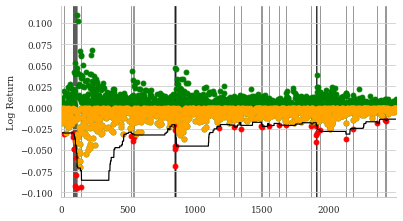

In [135]:
var_estimates_file = "VaR_estimates_generator_noisylabels_3leakyrelu_layers_dropout_8batch_output500_minkurtscore_50step_2000_train_days.txt"
with open(var_estimates_file, "rt") as var_estimates:
    value_at_risk_estimates = var_estimates.readlines()
    value_at_risk_estimates = numpy.array([float(item.strip()) for item in value_at_risk_estimates])
    

alpha = 0.01

test_returns = log_returns_numpy[10000:12500]
test_index = range(test_returns.shape[0])

print(value_at_risk_estimates)
var_backtest = Backtest(test_index, test_returns, -value_at_risk_estimates, alpha)

print()
print("GAN Christoffersen conditional coverage test")
print("statistic: {:.4f}".format(var_backtest.lr_bt()["Statistic"].iloc[2]))
print("p-value: {:.4f}".format(var_backtest.lr_bt()["p-value"].iloc[2]))
print()
print("GAN Dynamic quantile test")
print("statistic: {:.4f}".format(var_backtest.dq_bt()["Statistic"]))
print("p-value: {:.4f}".format(var_backtest.dq_bt()["p-value"]))
print()
print("GAN Ljung-Box test")
print("statistic: {:.4f}".format(var_backtest.ljung_box()[0]))
print("p-value: {:.4f}".format(var_backtest.ljung_box()[1]))
print()


hs_window = 250
var_estimates_historical = historical_simulation(price_index["log_return"], hs_window, alpha).iloc[10000:12500]
historical_var_backtest = Backtest(test_index, test_returns, var_estimates_historical.to_numpy(), alpha)

print("HS Christoffersen")
print("statistic: {:.4f}".format(historical_var_backtest.lr_bt()["Statistic"].iloc[2]))
print("p-value: {:.4f}".format(historical_var_backtest.lr_bt()["p-value"].iloc[2]))
print()
print("HS dynamic quantile")
print("statistic: {:.4f}".format(historical_var_backtest.dq_bt()["Statistic"]))
print("p-value: {:.4f}".format(historical_var_backtest.dq_bt()["p-value"]))
print()
print("HS Ljung-Box")
print("statistic: {:.4f}".format(historical_var_backtest.ljung_box()[0]))
print("p-value: {:.4f}".format(historical_var_backtest.ljung_box()[1]))

historical_var_backtest.plot()

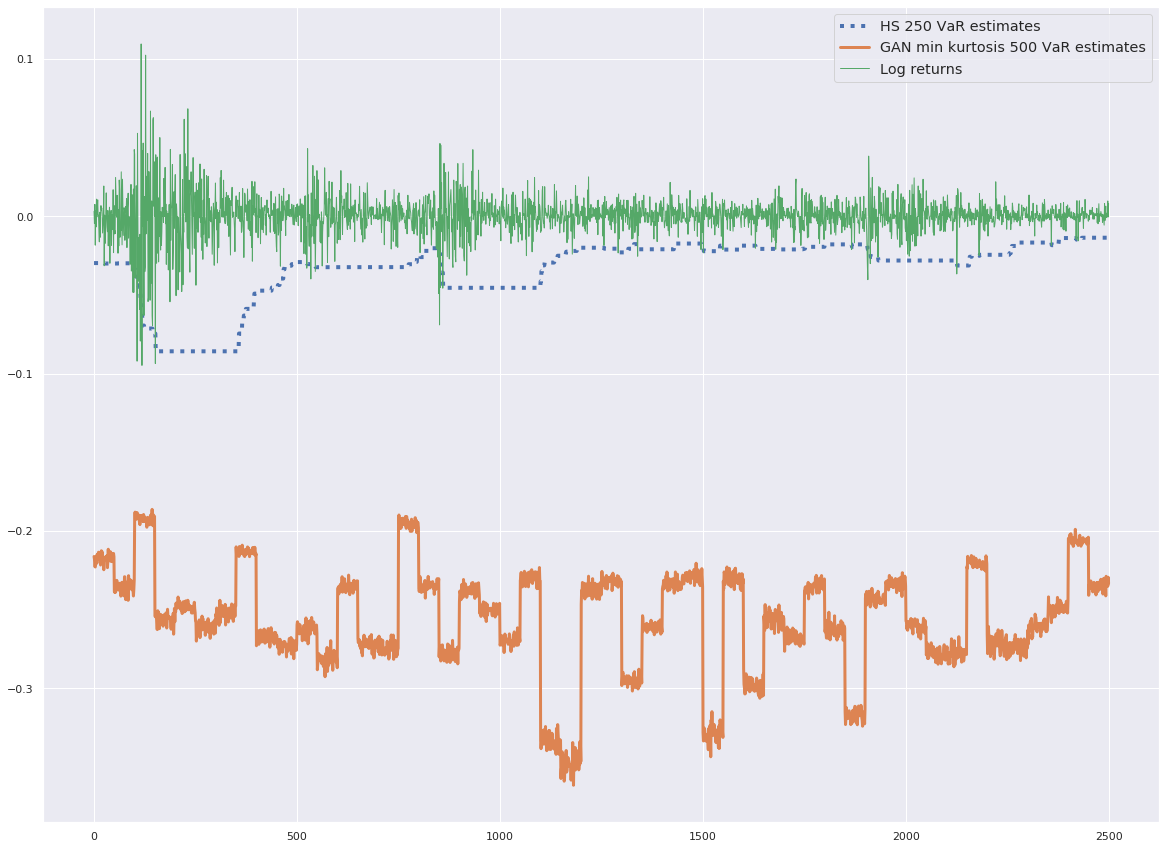

In [136]:
#seaborn.set()
seaborn.set()
pyplot.figure(figsize=(20,15))
pyplot.plot(var_estimates_historical.to_numpy(), label="HS 250 VaR estimates", linewidth=4, linestyle=":")
pyplot.plot(-value_at_risk_estimates, label="GAN min kurtosis 500 VaR estimates", linewidth=3, linestyle="-")
pyplot.plot(log_returns_numpy[10000:12500], label="Log returns", linewidth=1)
pyplot.legend(fontsize="large")
pyplot.show()